<a href="https://colab.research.google.com/github/AlexanderBelfort/MDPRKT/blob/main/TopicModelling_2_WordCloudAdded.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
# Run in python console
import nltk
nltk.download('stopwords')

# Run in terminal or command prompt
%pip install spacy
%pip install pyLDAvis==2.1.2

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
import re
import string
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [30]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

# Import Dataset
df = pd.read_csv('3.txt', sep='\t')
#print(df.target_names.unique())
#df.head()

# testing

#print(df.columns)
# returns R - Researcher and P - Participant which are not great names for columns
# df.columns[0]
# needs renaming to CONTENT
col_name = df.columns[0]
df=df.rename(columns = {col_name:'content'})
# testing
# df.columns[0]
# returns content now

df.head()

,content,P = Participant
0,[start of audio recording 17015_171004_0029_05...,NaN
1,R1 - … ID 17015. Date today is 5 October 2017.,NaN
2,"R2 - Right, so I had a look at your scan and y...",NaN
3,P - Yes.,NaN
4,R2 - What sort of trouble are they causing you?,NaN


In [31]:
# DATA CLEANING STEP
#
#
# Convert to list
data = df.content.values.tolist()

# Remove new line characters
data = [re.sub('\s+', ' ', token) for token in data]

# Remove distracting single quotes
data = [re.sub("\'", "", token) for token in data]

# remove text in square brackets like [surgeon], [name]
data = [re.sub('\[.*?\]', '', token) for token in data]

# remove numbers
data = [re.sub('\w*\d\w*', '', token) for token in data]

# remove punctuation
# might not be necessary now / we can do it later
# data = [re.sub('[%s]' % re.escape(string.punctuation), '', token) for token in data]

# all to lower
data = [word.lower() for word in data]

# filter out short tokens like P and R and i
# neccessary?
#data = [re.sub(r'\b\w{1,1}\b', '', token) for token in data]


pprint(data[:5])

['',
 ' - … id . date today is  october .',
 ' - right, so i had a look at your scan and you’ve got some gallstones.',
 'p - yes.',
 ' - what sort of trouble are they causing you?']


In [32]:
# Let’s tokenize each sentence into a list of words
# removing punctuations and unnecessary characters altogether
# on this step

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:15])

[[], ['id', 'date', 'today', 'is', 'october'], ['right', 'so', 'had', 'look', 'at', 'your', 'scan', 'and', 'you', 've', 'got', 'some', 'gallstones'], ['yes'], ['what', 'sort', 'of', 'trouble', 'are', 'they', 'causing', 'you'], ['was', 'just', 'telling', 'just', 'now', 'feel', 'constantly', 'bloated', 'can', 'get', 'shot', 'of', 'that', 'but', 'when', 'in', 'the', 'bath', 'and', 'raise', 'this', 'leg', 'it', 'feels', 'like', 'being', 'strangled', 'there', 'so', 'did', 'say', 'to', 'my', 'doctor', 'before', 'and', 'that', 'when', 'he', 'referred', 'me', 'then', 'to', 'have', 'scan', 'done', 'on', 'my', 'see', 'if', 've', 'got', 'gallstones', 'but', 'it', 'like', 'it', 'hasn', 'played', 'up', 'for', 'while', 'now', 'it', 'been', 'okay', 'but', 'like', 'said', 'every', 'time', 'have', 'bath', 'that', 'starts', 'so', 'push', 'the', 'stomach', 'in', 'and', 'think', 'right', 'let', 'wait', 'five', 'minutes', 'now', 'll', 'soon', 'pass', 'and', 'it', 'does', 'but', 'don', 'like', 'that', 'pain

In [33]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

# this does not work so good as the words
# gallblader surgery
# laporscopic cholefcystemy
# or any of that kind do not really appear often
# maybe mentioned once




[]


/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [34]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [35]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:5])

# # # # # # # # # 
## # # # # # 
##
#

[[], ['would', 'date', 'today'], ['look', 'scan', 'get', 'gallstone'], [], ['sort', 'trouble', 'cause']]


In [36]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:5])

# words really are not repeated that often :/
# maximum of two repetitions in the first sentence
# that is why I added would 5 times at index 1
# print(corpus[1])

[[], [(0, 1), (1, 1), (2, 1)], [(3, 1), (4, 1), (5, 1), (6, 1)], [], [(7, 1), (8, 1), (9, 1)]]


In [37]:
# testing if the word with id 25 is actually would
# id2word[26]
# out: would
# test passed
# # # # # # # # # # # # # # # # # # # #

In [38]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:2]]

[[], [('date', 1), ('today', 1), ('would', 1)]]

In [39]:
# # # # # # # # # # # # # # # # #
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [40]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.059*"computer" + 0.056*"go" + 0.041*"detail" + 0.041*"need" + '
  '0.036*"button" + 0.036*"press" + 0.029*"put" + 0.024*"say" + 0.024*"able" + '
  '0.021*"dark"'),
 (1,
  '0.070*"personal" + 0.066*"go" + 0.053*"special" + 0.041*"darling" + '
  '0.041*"purpose" + 0.036*"number" + 0.028*"try" + 0.028*"look" + '
  '0.028*"tape" + 0.028*"lovely"'),
 (2,
  '0.078*"expire" + 0.024*"quiet" + 0.023*"bit" + 0.013*"iron" + '
  '0.013*"together" + 0.013*"tablet" + 0.013*"acid" + 0.013*"folic" + '
  '0.013*"section" + 0.013*"period"'),
 (3,
  '0.039*"life" + 0.039*"question" + 0.037*"get" + 0.036*"right" + '
  '0.032*"leave" + 0.027*"questionnaire" + 0.026*"say" + 0.026*"randomise" + '
  '0.025*"operation" + 0.022*"quality"'),
 (4,
  '0.027*"get" + 0.021*"tramadol" + 0.021*"serious" + 0.021*"recurrent" + '
  '0.021*"minute" + 0.021*"take" + 0.017*"say" + 0.016*"gallstone" + '
  '0.011*"month" + 0.011*"acid"'),
 (5,
  '0.056*"expire" + 0.035*"never" + 0.029*"perspire" + 0.029*"mind" + '
 

In [41]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.53812608755137

Coherence Score:  0.46112947424991574


In [42]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.136485 -0.068847       1        1  17.250715
0     -0.002681  0.052241       2        1  14.856356
6      0.061684  0.064828       3        1  12.583305
9      0.014399  0.003644       4        1  11.415463
5      0.075346  0.004439       5        1   9.128677
1     -0.186626  0.143817       6        1   9.126748
8     -0.154235 -0.220359       7        1   8.141032
4      0.035403 -0.033915       8        1   7.581046
2      0.036531  0.001659       9        1   4.960834
7     -0.016306  0.052493      10        1   4.955824, topic_info=          Term       Freq      Total Category  logprob  loglift
2        would  10.000000  10.000000  Default  30.0000  30.0000
65          go  18.000000  18.000000  Default  29.0000  29.0000
269     expire   9.000000   9.000000  Default  28.0000  28.0000
300   personal   4.000000   4.000000  Default  27.0000  27.0000
34       think   8.000000   8.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
248      quiet   0.058889   1.406865  Topic10  -6.2905  -0.1689
251       tape   0.058888   2.314106  Topic10  -6.2905  -0.6665
235  randomise   0.058880   4.007153  Topic10  -6.2907  -1.2157
4          get   0.058879   9.365983  Topic10  -6.2907  -2.0647
162      happy   0.058878   1.541046  Topic10  -6.2907  -0.2601

[419 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
151       2  0.698530        able
211       4  0.714876  absolutely
68        8  0.656762        acid
261       1  0.808818    actually
200       8  0.852601         ago
...     ...       ...         ...
312       7  0.623846        wise
2         3  0.935149       would
253       3  0.493710       wrong
67        2  0.467175      yellow
67        8  0.467175      yellow

[355 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 7, 10, 6, 2, 9, 5, 3, 8])

In [43]:
%matplotlib inline
vis = pyLDAvis.gensim.prepare(topic_model=lda_model, corpus=corpus, dictionary=id2word)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

**Create a wordcloud from all text files**

In [50]:
filenames = ['1.txt', '2.txt', '3.txt']
with open('new.txt', 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                outfile.write(line)

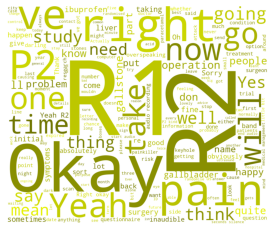

In [51]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS


def random_color_func(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    h = int(360.0 * 45.0 / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)

file_content=open ("new.txt").read()

wordcloud = WordCloud(
                            stopwords = STOPWORDS,
                            background_color = 'white',
                            width = 1200,
                            height = 1000,
                            color_func = random_color_func
                            ).generate(file_content)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()